In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
from datetime import datetime
import datetime
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from statsmodels.graphics import tsaplots

# Import sklearn 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Load the data

df = pd.read_csv("/content/drive/MyDrive/Data_sets/Walmart_Store_sales.csv")

df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [25]:
## Changing Date to format 

df['Date'] =  pd.to_datetime(df['Date'], format = "%d-%m-%Y")

## Changine Weekely Sales Variable 

df["Weekly_Sales"] = (df["Weekly_Sales"]/1000000)

In [26]:
df.describe()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,0.564367,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,0.209986,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,0.553350,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,0.960746,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686,1.000000,100.140000,4.468000,227.232807,14.313000


In [27]:
## Describation of the data

print(df.describe().to_latex(index=True))  

\begin{tabular}{lrrrrrrr}
\toprule
{} &        Store &  Weekly\_Sales &  Holiday\_Flag &  Temperature &   Fuel\_Price &          CPI &  Unemployment \\
\midrule
count &  6435.000000 &   6435.000000 &   6435.000000 &  6435.000000 &  6435.000000 &  6435.000000 &   6435.000000 \\
mean  &    23.000000 &      1.046965 &      0.069930 &    60.663782 &     3.358607 &   171.578394 &      7.999151 \\
std   &    12.988182 &      0.564367 &      0.255049 &    18.444933 &     0.459020 &    39.356712 &      1.875885 \\
min   &     1.000000 &      0.209986 &      0.000000 &    -2.060000 &     2.472000 &   126.064000 &      3.879000 \\
25\%   &    12.000000 &      0.553350 &      0.000000 &    47.460000 &     2.933000 &   131.735000 &      6.891000 \\
50\%   &    23.000000 &      0.960746 &      0.000000 &    62.670000 &     3.445000 &   182.616521 &      7.874000 \\
75\%   &    34.000000 &      1.420159 &      0.000000 &    74.940000 &     3.735000 &   212.743293 &      8.622000 \\
max   &    45.000

In [28]:
%%capture --no-display
## custom df_norm here

## count the Nth week of the month
def week_counter(x):
    counters = []
    counter = 1

    for i in range(len(x)):
        if i == 0:
            counter == 1
        else:
            if x[i] == x[i-1]:
                counter += 1
            else:
                counter = 1

        counters.append(counter)
    
    return counters

## idneitfy holiday and add pre/post holiday
def event_creator(date, holiday):
    events = []
    for i in range(len(date)):
        if (date[i].month == 2) & (holiday[i] == 1):
            event = "super_bowl"
        elif (date[i].month == 9) & (holiday[i] == 1):
            event = "labor_day"
        elif (date[i].month == 11) & (holiday[i] == 1):
            event = "thanksgiving"
        elif (date[i].month == 12) & (holiday[i] == 1):
            event = "christmas"
        else:
            event = "non_holiday"

        events.append(event)

    for i in range(len(events)):
        if events[i-1] == "thanksgiving":
            events[i] = "post_thanksgiving"
        elif events[i] == "christmas":
            events[i-1] = "pre-christmas_1"
            events[i-2] = "pre-christmas_2"
    return events

### copy df
df_norm = df.copy()

### standardize all numeric data
df_norm = df_norm.groupby("Store").transform(lambda x: (x - np.mean(x))/np.std(x))

### restore variables which are not to be standardized
df_norm[["Date", "Holiday_Flag", "Store"]] = df[["Date", "Holiday_Flag", "Store"]]

### get month col
df_norm["month"] = [x.month for x in df_norm["Date"]]

### get Xth week of the month col
df_norm["weeks"] = week_counter(df_norm["month"])

### get idntified events info
df_norm["events"] = event_creator(df_norm["Date"], df_norm["Holiday_Flag"])


      3-1. Weekly Sales


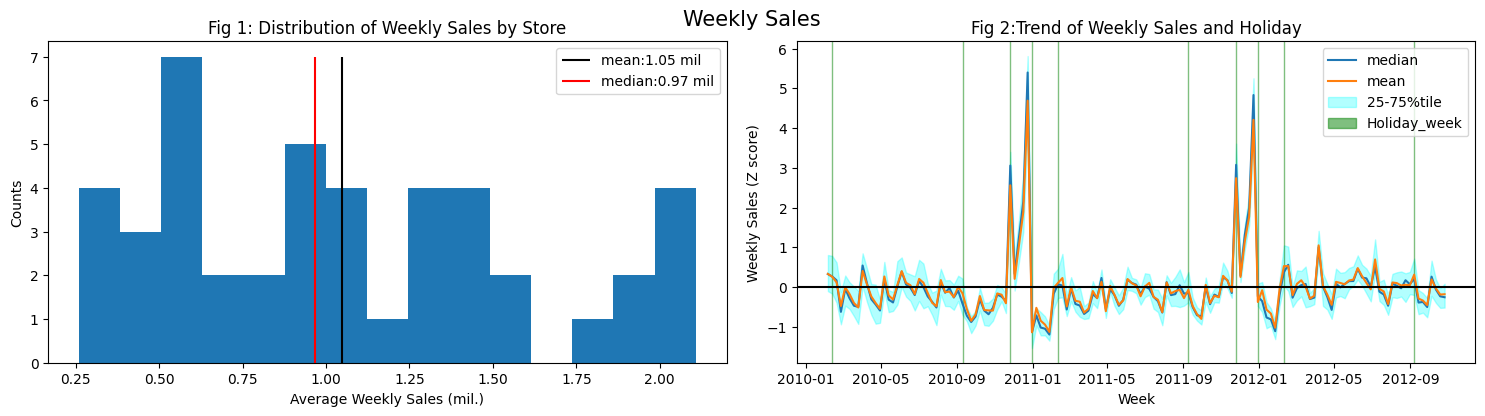

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
fig.tight_layout(w_pad = 2)
fig.suptitle("Weekly Sales", fontsize = 15)
plt.subplots_adjust(top=0.9)

## ax1
temp = df.groupby("Store").agg([np.mean])["Weekly_Sales"]

mean_value   = np.mean(temp["mean"])
median_value = np.median(temp["mean"])

axs[0].hist(temp["mean"], bins = 15)
axs[0].vlines(x = mean_value, ymin = 0, ymax = 7, color = "black", label = f"mean:{mean_value:.2f} mil")
axs[0].vlines(x = median_value, ymin = 0, ymax = 7, color = "red", label = f"median:{median_value:.2f} mil")

axs[0].set_title("Fig 1: Distribution of Weekly Sales by Store")
axs[0].set_xlabel("Average Weekly Sales (mil.)")
axs[0].set_ylabel("Counts")
axs[0].legend()

## ax2
df_holi = df_norm[df_norm["Store"] == 1]
temp = df_norm.groupby("Date").agg("describe").Weekly_Sales[["25%", "50%", "75%", "mean"]]

axs[1].plot(temp.index.values, temp["50%"],  label = "median")
axs[1].plot(temp.index.values, temp["mean"], label = "mean")
axs[1].fill_between(temp.index.values, temp["25%"], temp["75%"], color = "aqua", alpha = 0.3, label = "25-75%tile")
axs[1].fill_between(df_holi["Date"], 0, 1, where = df_holi["Holiday_Flag"],
                color = "green", alpha = 0.5, transform = axs[1].get_xaxis_transform(), label = "Holiday_week")

axs[1].legend()
axs[1].axhline(y=0, color = "black")
axs[1].set_title("Fig 2:Trend of Weekly Sales and Holiday")
axs[1].set_ylabel("Weekly Sales (Z score)")
axs[1].set_xlabel("Week")

fig.savefig('1-2_weekly_sales.png')


we see a huge variation in the average weekly sales of stores. There are many stores with average weekly sales of less than half a million dollars, yet there are stores with average weekly sales of over two million dollars. To capture these heterogeneity, we would have to include store-specific fixed effects in the model we will develop later. Fig 2 shows the trend and seasonality of weekly sales, drawing the standardized weekly sales by each store. While there may not be explicit trend over time, the weekly sales are never smooth. Particularly, There are two huge spikes in November and December. It seems like these spikes are corresponding to the holiday, Thanksgiving and Christmas, respectively. While the spike in November perfectly corresponds with Thanksgiving, the spike in December comes one week before Christmas. Furthermore, we observe some decrease in weekly sales before Thanksgiving and after Christmas. This suggests that weekly sales have seasonality associated with holidays. Thus, we should identify each holiday and add pre/post big events, such as Thanksgiving and Christmas, assuming the impact of holiday is heterogeneous.

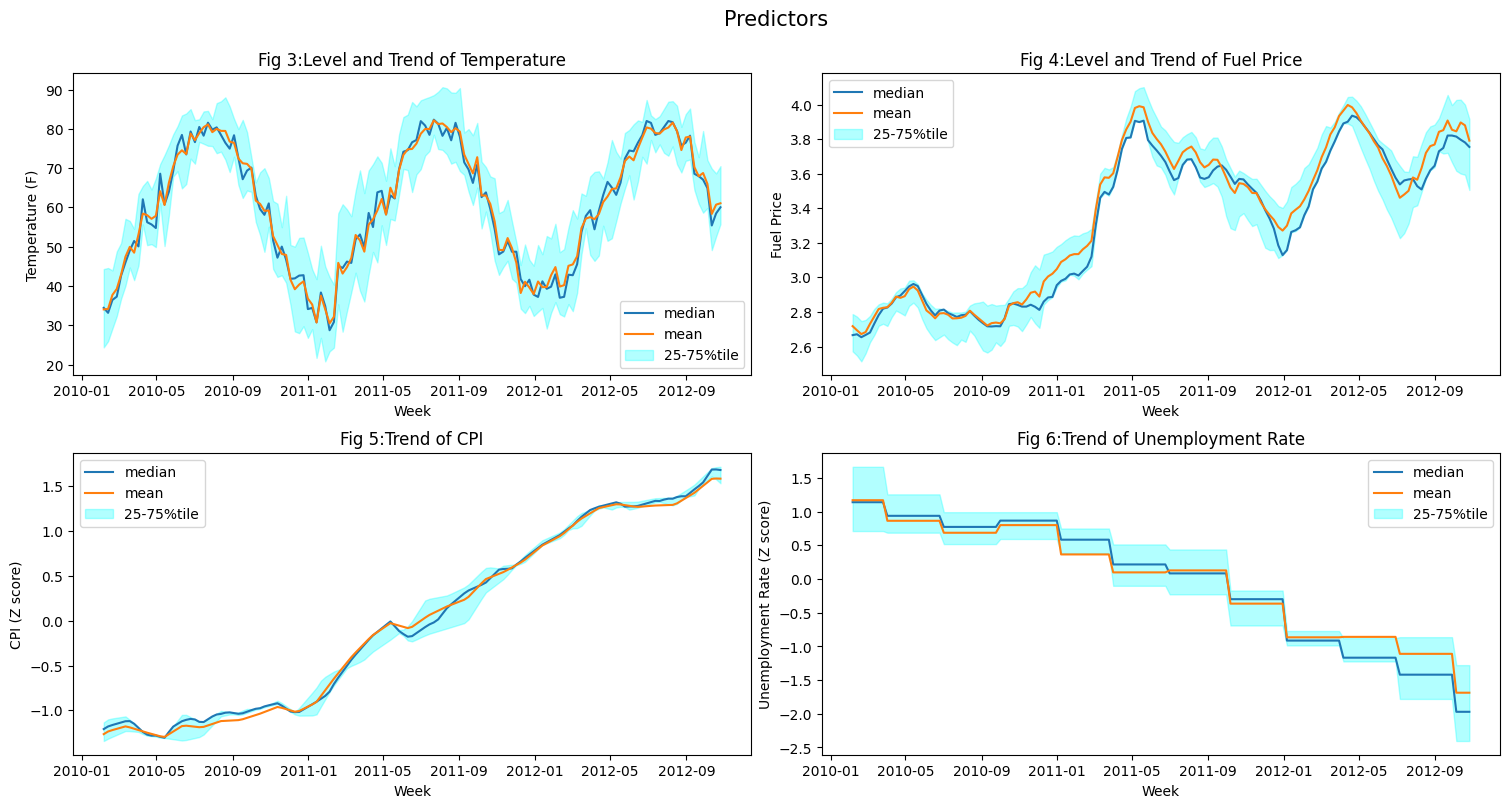

In [30]:
fig, axs = plt.subplots(2, 2, figsize = (15, 8))
fig.tight_layout(h_pad = 4,  w_pad = 2)
fig.suptitle("Predictors", fontsize = 15)
plt.subplots_adjust(top=0.9)

## ax1
temp = df.groupby("Date").agg("describe").Temperature

axs[0,0].plot(temp.index.values, temp["50%"],  label = "median")
axs[0,0].plot(temp.index.values, temp["mean"], label = "mean")
axs[0,0].fill_between(temp.index.values, temp["25%"], temp["75%"], color = "aqua", alpha = 0.3, label = "25-75%tile")
axs[0,0].legend()
axs[0,0].set_title("Fig 3:Level and Trend of Temperature")
axs[0,0].set_ylabel("Temperature (F)")
axs[0,0].set_xlabel("Week")

## ax2
temp = df.groupby("Date").agg("describe").Fuel_Price

axs[0,1].plot(temp.index.values, temp["50%"],  label = "median")
axs[0,1].plot(temp.index.values, temp["mean"], label = "mean")
axs[0,1].fill_between(temp.index.values, temp["25%"], temp["75%"], color = "aqua", alpha = 0.3, label = "25-75%tile")
axs[0,1].legend()
axs[0,1].set_title("Fig 4:Level and Trend of Fuel Price")
axs[0,1].set_ylabel("Fuel Price")
axs[0,1].set_xlabel("Week")

## ax3
temp = df_norm.groupby("Date").agg("describe").CPI

axs[1,0].plot(temp.index.values, temp["50%"],  label = "median")
axs[1,0].plot(temp.index.values, temp["mean"], label = "mean")
axs[1,0].fill_between(temp.index.values, temp["25%"], temp["75%"], color = "aqua", alpha = 0.3, label = "25-75%tile")
axs[1,0].legend()
axs[1,0].set_title("Fig 5:Trend of CPI")
axs[1,0].set_ylabel("CPI (Z score)")
axs[1,0].set_xlabel("Week")

## ax4
temp = df_norm.groupby("Date").agg("describe").Unemployment

axs[1,1].plot(temp.index.values, temp["50%"],  label = "median")
axs[1,1].plot(temp.index.values, temp["mean"], label = "mean")
axs[1,1].fill_between(temp.index.values, temp["25%"], temp["75%"], color = "aqua", alpha = 0.3, label = "25-75%tile")
axs[1,1].legend()
axs[1,1].set_title("Fig 6:Trend of Unemployment Rate")
axs[1,1].set_ylabel("Unemployment Rate (Z score)")
axs[1,1].set_xlabel("Week")

fig.savefig('3-6_predictors.png')


We have four predictors other than holidays; temperature, fuel price, CPI, and unemployment rate. Temperature (Fig 3) shows strong seasonality over the year, hot from June to August and cold from December to February. Fuel Price (Fig 4) shows some level shift from 2011. After 2011, it shows some fluctuation, high in May. But, It is hard to tell whether it is seasonality or fluctuations in global commodity prices. CPI (Fig 5) shows a clear upward trend over time. The unemployment rate (Fig 6) is updated monthly, and it has a clear downward trend over time.

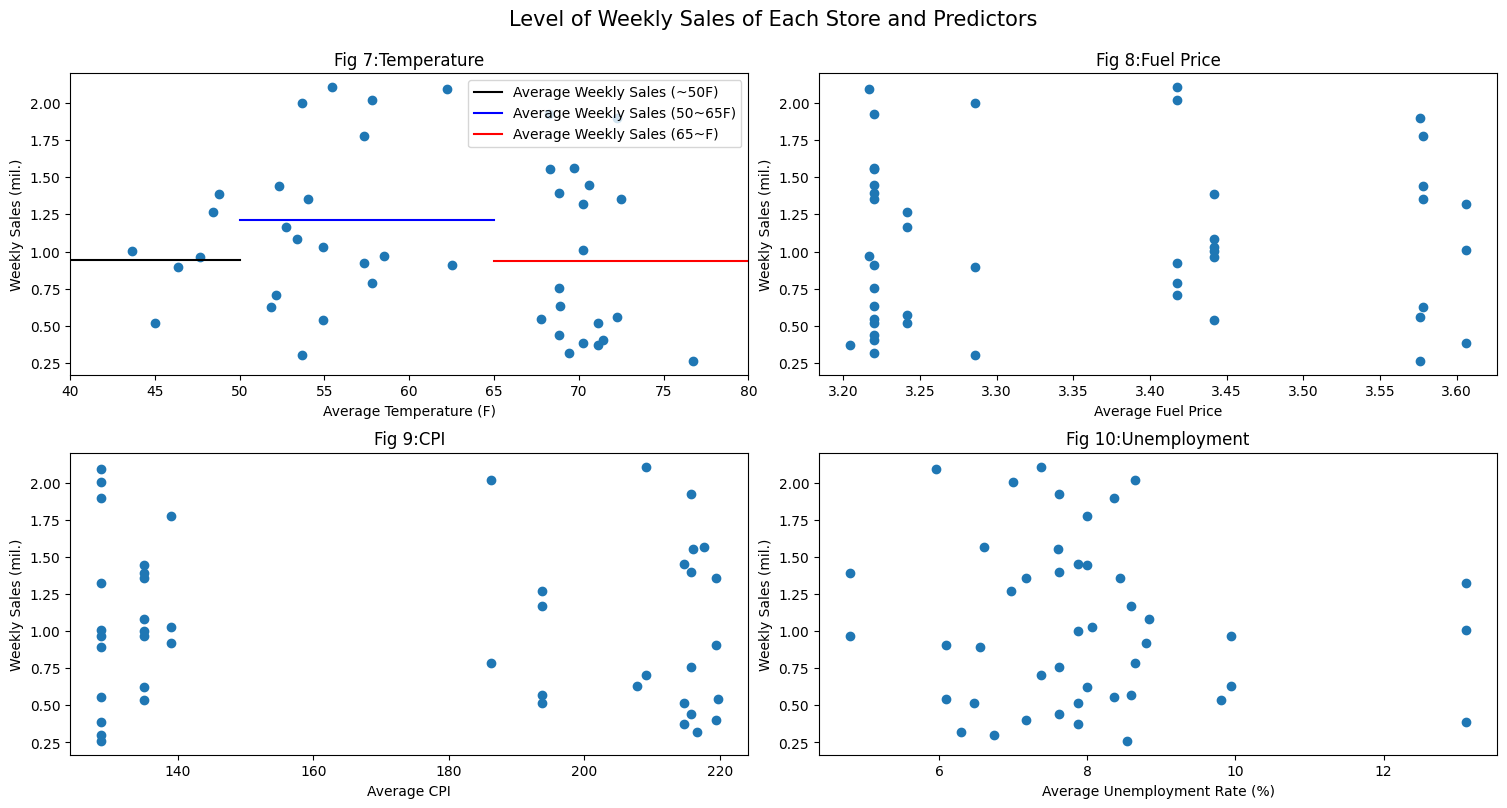

In [31]:
fig, axs = plt.subplots(2, 2, figsize = (15, 8))
fig.tight_layout(h_pad = 4,  w_pad = 2)
fig.suptitle("Level of Weekly Sales of Each Store and Predictors", fontsize = 15)
plt.subplots_adjust(top=0.9)

temp = pd.merge(df_norm[["Store", "Date", "events"]], 
                df[["Store", "Date", "Weekly_Sales", "Temperature", "Fuel_Price","CPI","Unemployment"]],
                how='left', on = ["Store", "Date"])

temp = temp.groupby("Store").agg("mean")

#############################################################################
# Weekly sales and temprature category 
temp1 = temp.copy()
temp1["temp_category"] =0
temp1.loc[temp['Temperature'] >50 , 'temp_category'] = 1 
temp1.loc[temp['Temperature'] > 65, 'temp_category'] = 2  

group_means=temp1.groupby("temp_category").agg("mean")

temp1.loc[temp1['temp_category'] ==0 , 'Weekly_Sales'] = group_means.Weekly_Sales[0]
temp1.loc[temp1['temp_category'] ==1 , 'Weekly_Sales'] = group_means.Weekly_Sales[1]
temp1.loc[temp1['temp_category'] ==2 , 'Weekly_Sales'] = group_means.Weekly_Sales[2]

##################################################################
#
## ax1
axs[0,0].plot(temp["Temperature"], temp["Weekly_Sales"], "o")
axs[0,0].set_xlim(40, 80)
axs[0,0].axhline(y=group_means.Weekly_Sales[0], xmin= 0, xmax = (50 - 40) / (80-40), color = "black", label = "Average Weekly Sales (~50F)")
axs[0,0].axhline(y=group_means.Weekly_Sales[1], xmin= (50 - 40) / (80-40), xmax = (65 - 40) / (80-40), color = "blue",label = "Average Weekly Sales (50~65F)")
axs[0,0].axhline(y=group_means.Weekly_Sales[2], xmin= (65 - 40) / (80-40), xmax = (80 - 40) / (80-40), color = "red",label = "Average Weekly Sales (65~F)")
axs[0,0].set_title("Fig 7:Temperature")
axs[0,0].set_xlabel("Average Temperature (F)")
axs[0,0].set_ylabel("Weekly Sales (mil.)")
axs[0,0].legend()



## ax2
axs[0,1].plot(temp["Fuel_Price"], temp["Weekly_Sales"], "o")
axs[0,1].set_title("Fig 8:Fuel Price")
axs[0,1].set_xlabel("Average Fuel Price")
axs[0,1].set_ylabel("Weekly Sales (mil.)")

## ax3
axs[1,0].plot(temp["CPI"], temp["Weekly_Sales"], "o")
axs[1,0].set_title("Fig 9:CPI")
axs[1,0].set_xlabel("Average CPI")
axs[1,0].set_ylabel("Weekly Sales (mil.)")

## ax4
axs[1,1].plot(temp["Unemployment"], temp["Weekly_Sales"], "o")
axs[1,1].set_title("Fig 10:Unemployment")
axs[1,1].set_xlabel("Average Unemployment Rate (%)")
axs[1,1].set_ylabel("Weekly Sales (mil.)")

fig.savefig('7-10_level_sales.png')


Examining the relationship between the level of weekly sales and predictors (Fig 7-10), it seems like no predictors have a clear association with weekly sales. Only Temperature (Fig 7) may have some implication for the level of sales. The average weekly sales in the moderate temperature is higher than other temperature zone. This could be because consumers in the moderate climate tend to buy more, or the Walmart tend to have larger stores in locations with moderate climate. Yet, we should be cautious as variance looks huge, Overall, this lack of explanatory power of levels implies that it would be almost impossible to predict the level of sales without store-fixed effects.

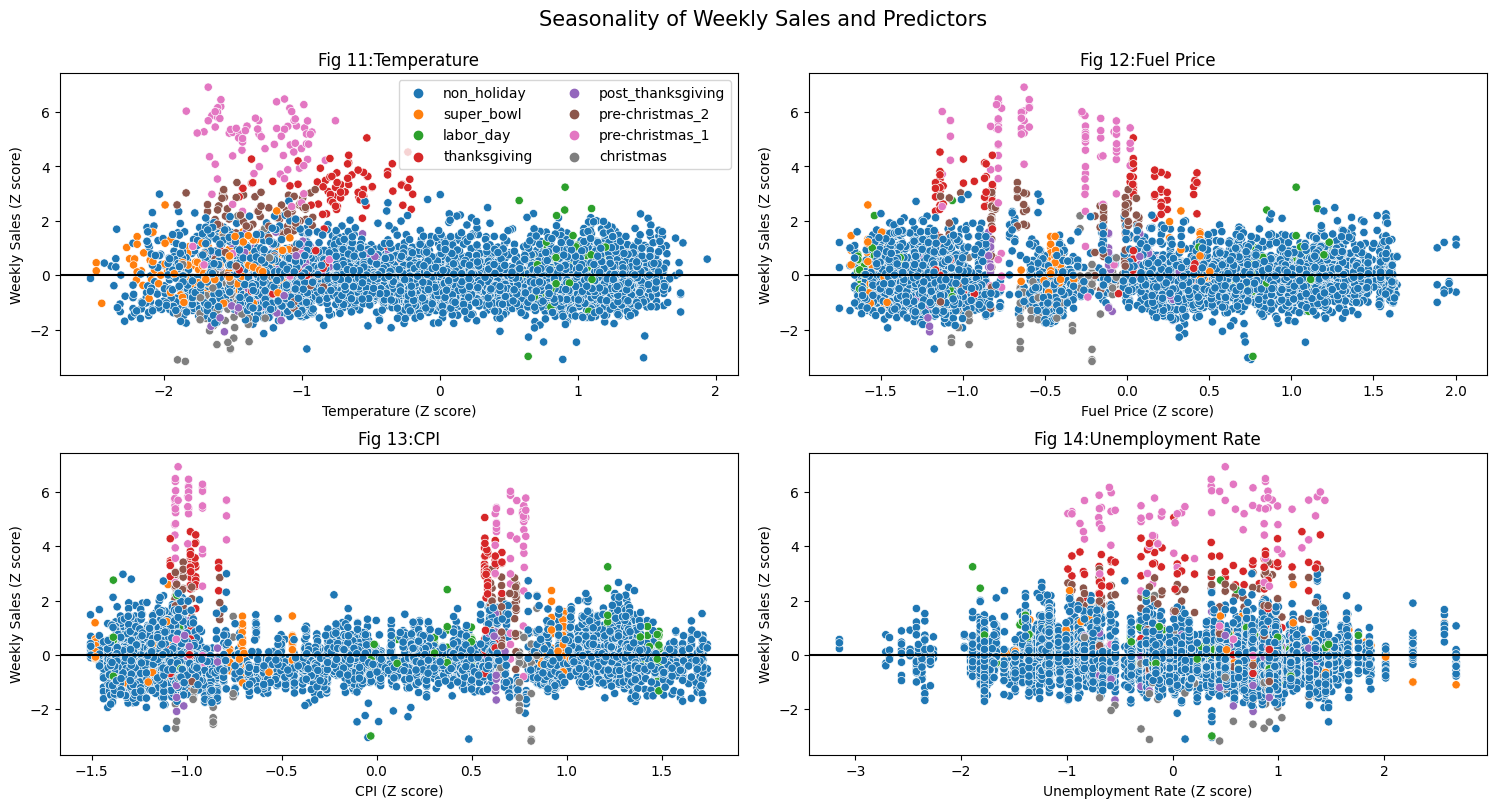

In [32]:
fig, axs = plt.subplots(2, 2, figsize = (15, 8))
fig.tight_layout(h_pad = 4,  w_pad = 2)
fig.suptitle("Seasonality of Weekly Sales and Predictors", fontsize = 15)
plt.subplots_adjust(top=0.9)

temp = df_norm.copy()

## ax1
sns.scatterplot(ax = axs[0,0], x='Temperature', y='Weekly_Sales', hue='events', data=temp) 
axs[0,0].axhline(y=0, color = "black")
axs[0,0].set_title("Fig 11:Temperature")
axs[0,0].set_xlabel("Temperature (Z score)")
axs[0,0].set_ylabel("Weekly Sales (Z score)")
axs[0,0].legend(loc='upper right', title = None, ncol = 2)

## ax2
sns.scatterplot(ax = axs[0,1], x='Fuel_Price', y='Weekly_Sales', hue='events', data=temp) 
axs[0,1].axhline(y=0, color = "black")
axs[0,1].set_title("Fig 12:Fuel Price")
axs[0,1].set_xlabel("Fuel Price (Z score)")
axs[0,1].set_ylabel("Weekly Sales (Z score)")
axs[0,1].get_legend().remove()

## ax3
sns.scatterplot(ax = axs[1,0], x='CPI', y='Weekly_Sales', hue='events', data=temp) 
axs[1,0].axhline(y=0, color = "black")
axs[1,0].set_title("Fig 13:CPI")
axs[1,0].set_xlabel("CPI (Z score)")
axs[1,0].set_ylabel("Weekly Sales (Z score)")
axs[1,0].get_legend().remove()

## ax4
sns.scatterplot(ax = axs[1,1], x='Unemployment', y='Weekly_Sales', hue='events', data=temp) 
axs[1,1].axhline(y=0, color = "black")
axs[1,1].set_title("Fig 14:Unemployment Rate")
axs[1,1].set_xlabel("Unemployment Rate (Z score)")
axs[1,1].set_ylabel("Weekly Sales (Z score)")
axs[1,1].get_legend().remove()

fig.savefig('11-14_seasonality_sales.png')


We examine if any predictors can explain the seasonality of weekly sales. To eliminate the impact of holidays and events, we check the distribution of non_holiday (blue marker). It seems that all predictors fail to explain the seasonality of weekly sales.

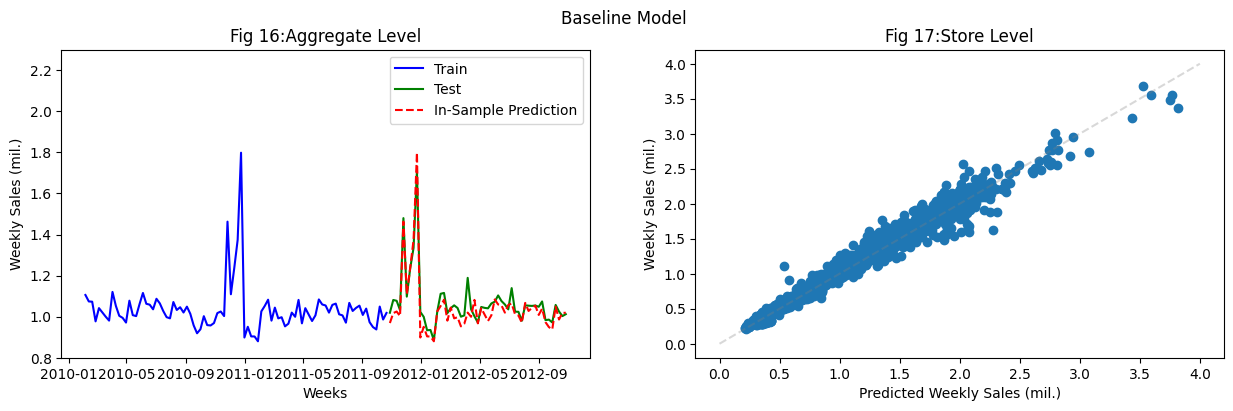

In [33]:
train_size = train_size = int(90)
random_state = 100
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
fig.suptitle("Baseline Model")

## ax1
############
agg_mean = df.groupby("Date").agg("mean")

values = pd.DataFrame(agg_mean["Weekly_Sales"].values)
baseline_df = pd.concat([values.shift(52), pd.DataFrame(values)], axis = 1)
baseline_df.columns = ['t-52', 't+52']

X = baseline_df.values

train, test = X[0:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistance(x):
    return x

predictions = list()
for x in test_X:
    yhat = model_persistance(x)
    predictions.append(yhat)

MSE_base_agg = metrics.mean_squared_error(test_y, predictions)
##########

x = df["Date"].unique()

axs[0].plot(x, [x for x in train_y] + [None for x in test_y], color = "blue", label = "Train")
axs[0].plot(x, [None for i in train_y] + [x for x in test_y], color='green', label='Test')
axs[0].plot(x, [None for i in train_y] + [x for x in predictions],  '--',color='red', label='In-Sample Prediction')
axs[0].set_xlabel("Weeks")
axs[0].set_ylabel("Weekly Sales (mil.)")
axs[0].set_ylim(0.8, 2.3)
axs[0].legend()
axs[0].set_title("Fig 16:Aggregate Level")

## ax2

temp = df[["Date", "Store", "Weekly_Sales"]]
temp["Weekly_Sales_lag52"] = temp.groupby("Store")["Weekly_Sales"].shift(52)
temp = temp.groupby("Store").apply(lambda x: x[train_size:])
y_test  = temp["Weekly_Sales"].values
X_test = temp["Weekly_Sales_lag52"].values
MSE_base_store = metrics.mean_squared_error(X_test, y_test)


axs[1].plot(X_test, y_test, "o")
x = np.arange(0,5)
axs[1].plot(x, x,'--', color = "gray", alpha = 0.3)
axs[1].set_title("Fig 17:Store Level")
axs[1].set_ylabel("Weekly Sales (mil.)")
axs[1].set_xlabel("Predicted Weekly Sales (mil.)")

fig.savefig('16-17_Baseline_Model.png')

In [34]:
%%capture --no-display

## custom dataset for prediction
df_pred = df.copy()
df_pred['Date'] =  pd.to_datetime(df_pred['Date'], format="%d-%m-%Y")

### get month col
#df_pred["month"] = [x.month for x in df_pred["Date"]]
df_pred['month'] = df_pred['Date'].dt.month

# ### get Xth week of the month col
df_pred["weeks_month"] = week_counter(df_pred["month"])

### get Xth week of the year col
df_pred["weeks_year"] = [x.isocalendar()[1] for x in df_pred["Date"]]

### get idntified events info
df_pred["events"] = event_creator(df_pred["Date"], df_pred["Holiday_Flag"])


### change the data type 
#### object: Store, Holiday_Flag, year, month, weeks_month, weeks_year, events
cols_object = ["Store", "Holiday_Flag", "month", "weeks_month", "weeks_year", "events"]

#### numeric: Weekly_Sales, "Temperature", "Fuel_Price", "CPI", "Unemployment"
cols_numeric = df_pred.columns[df_pred.dtypes == "float64"]


## one hot encode
df_pred = pd.get_dummies(df_pred, columns = cols_object, drop_first = True)

## restore original store index for reference
df_pred["Store"] = df["Store"]

In [35]:
df_pred.head()
df_pred["Date"] = pd.to_datetime(df_pred["Date"])

df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Columns: 125 entries, Date to Store
dtypes: datetime64[ns](1), float64(5), int64(1), uint8(118)
memory usage: 1.1 MB


In [36]:
df_pred['Year']=df['Date'].dt.year
df_pred['Month']=df['Date'].dt.month
df_pred['Day']=df['Date'].dt.day
df_pred=df_pred.drop('Date',axis='columns')

In [37]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Columns: 127 entries, Weekly_Sales to Day
dtypes: float64(5), int64(4), uint8(118)
memory usage: 1.2 MB


In [38]:
X = df_pred.drop('Weekly_Sales',axis='columns')
y = df_pred.Weekly_Sales

In [39]:
# Spliting the data into Training set & Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [40]:
 #  Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
A1 = LinearRegression()
A1.fit(X_train, y_train)

y_pred_train = A1.predict(X_train)
print("Train R2")

print(r2_score(y_train, y_pred_train))
y_pred_lr_reg = A1.predict(X_test)
print("Test R2")
r2_score(y_test, y_pred_lr_reg)

Train R2
0.9622578526222778
Test R2


0.9626120868824863

Hyper parameter Tuning for Regression:




In [46]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV


# Define the hyperparameters and their possible values
param_grid = {'alpha': [0.1, 1, 10]}

# Create a Ridge or Lasso regressor
ridge_reg = Ridge()
lasso_reg = Lasso()

# Use GridSearchCV to evaluate different combinations of hyperparameters
grid_search_ridge = GridSearchCV(ridge_reg, param_grid, cv=5)
grid_search_ridge.fit(X_train, y_train)

grid_search_lasso = GridSearchCV(lasso_reg, param_grid, cv=5)
grid_search_lasso.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters for Ridge:", grid_search_ridge.best_params_)
print("Best hyperparameters for Lasso:", grid_search_lasso.best_params_)

print("*******. Ridge Regression ********")
y_predict=grid_search_ridge.predict(X_test)
y_predict_train=grid_search_ridge.predict(X_train)

print(' Train r2_score',r2_score(y_train,y_predict_train))

print(' Test r2_score',r2_score(y_test,y_predict))


print("******* Lasso  Regression ********")


y_predict=grid_search_lasso.predict(X_test)
y_predict_train=grid_search_lasso.predict(X_train)

print('Train r2_score',r2_score(y_train,y_predict_train))

print('  Test r2_score',r2_score(y_test,y_predict))


Best hyperparameters for Ridge: {'alpha': 0.1}
Best hyperparameters for Lasso: {'alpha': 0.1}
*******. Ridge Regression ********
 Train r2_score 0.9621963978661445
 Test r2_score 0.9625189656263627
******* Lasso  Regression ********
Train r2_score 0.13424432254407337
  Test r2_score 0.16128225651551786


    Random Forest 


In [45]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=110,random_state=1)
forest.fit(X_train,y_train)

y_predict=forest.predict(X_test)
y_predict_train=forest.predict(X_train)

print('Random Forest Train r2_score',r2_score(y_train,y_predict_train))

print('Random Forest Test r2_score',r2_score(y_test,y_predict))


Random Forest Train r2_score 0.9967553438319892
Random Forest Test r2_score 0.9771796269484241


    Hyper parameter tuning for Random Forest

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create a Random Forest regressor object
rf_regressor = RandomForestRegressor(random_state=42)

# Define the grid search parameters
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

# Create a grid search object
grid_search = GridSearchCV(
    estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

y_predict=grid_search.predict(X_test)
y_predict_train=grid_search.predict(X_train)

print('Random Forest Train r2_score',r2_score(y_train,y_predict_train))

print('Random Forest Test r2_score',r2_score(y_test,y_predict))


Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Random Forest Train r2_score 0.9509521385937959
Random Forest Test r2_score 0.9192129133909738


    Ada Boost 

In [48]:
from sklearn.ensemble import AdaBoostRegressor
ada_boost = AdaBoostRegressor(n_estimators=57, learning_rate=0.05, loss='exponential')
ada_boost.fit(X_train,y_train)

y_pred_ada_boost = ada_boost.predict(X_test)
y_pred_ada_train = ada_boost.predict(X_train)

print('Ada Boost Test r2_score',r2_score(y_test, y_pred_ada_boost))
print('Ada Boost Test r2_score',r2_score(y_train, y_pred_ada_train))

Ada Boost Test r2_score 0.4494285331184854
Ada Boost Test r2_score 0.448114019319779


    Hyper parameter tuning for Ada Boost

In [50]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor



# Create a Decision Tree regressor object
base_regressor = DecisionTreeRegressor()

# Create an AdaBoost regressor object
ada_regressor = AdaBoostRegressor(
    base_estimator=base_regressor, random_state=42)

# Define the grid search parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'base_estimator__max_depth': [5, 10, 20]
}

# Create a grid search object
grid_search = GridSearchCV(
    estimator=ada_regressor, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)


y_predict=grid_search.predict(X_test)
y_predict_train=grid_search.predict(X_train)

print('Ada Boost  Train r2_score',r2_score(y_train,y_predict_train))

print('Ada Boost Test r2_score',r2_score(y_test,y_predict))


Best parameters: {'base_estimator__max_depth': 20, 'learning_rate': 1, 'n_estimators': 200}
Ada Boost  Train r2_score 0.9995557993809873
Ada Boost Test r2_score 0.9830142695176692


    Extra Gradient Boost

In [51]:
from xgboost import XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(X_train,y_train)

y_predict=xgbr.predict(X_test)
y_predict_train=xgbr.predict(X_train)

print(' Extra Gradient Boosting   Train r2_score',r2_score(y_train,y_predict_train))

print('Extra Gradient Boosting  Test r2_score',r2_score(y_test,y_predict))



 Extra Gradient Boosting   Train r2_score 0.9974110878606209
Extra Gradient Boosting  Test r2_score 0.9842495276198501


    Hyper Parameter Tuning 

In [52]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split


# Define the XGBoost model
model = xgb.XGBRegressor()

# Define the hyperparameters to tune and their ranges
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

# Print the best hyperparameters and R-squared score on the test set
print("Best Hyperparameters:", grid_result.best_params_)


y_predict=grid_search.predict(X_test)
y_predict_train=grid_search.predict(X_train)

print(' Extra Gradient Boosting   Train r2_score',r2_score(y_train,y_predict_train))

print('Extra Gradient Boosting  Test r2_score',r2_score(y_test,y_predict))



Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
 Extra Gradient Boosting   Train r2_score 0.9972462493577774
Extra Gradient Boosting  Test r2_score 0.9847558862174449
